In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq

In [2]:
def visualization(signal):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    axs = axs.flatten()

    axs[0].imshow(np.real(signal), cmap="gray", aspect=1)
    axs[0].set_title("Real Part")

    axs[1].imshow(np.imag(signal), cmap="gray", aspect=1)
    axs[1].set_title("Imaginary Part")

    axs[3].imshow(np.angle(signal), cmap="gray", aspect=1)
    axs[3].set_title("Phase")

    axs[2].imshow(np.abs(signal), cmap="gray", aspect=1)
    axs[2].set_title("Magnitude")

    for ax in axs:
        ax.set_xlabel("Range")
        ax.set_ylabel("Azimuth")

    fig.tight_layout()
    plt.show()

### Parameters

In [3]:
Naz = 256
Nrg = 256

squint_angle = 0.2 * np.pi / 180

# Pulse Reputation Frequency (Hz)
PRF = 100
# Radar sampling rate (Hz)
Fr = 60e6
# Radar center frequency (Hz)
f0 = 5.300e9
# Speed of light (m/s)
c = 2.9979e8
# Slant range at scene center
R0 = 20e3
# FM rate of radar pulse (Hz/s)
Kr = 20e12
# Chirp duration (s)
Tr = 2.5e-6


# velocidade do radar
Vr = 150
# velocidade de vs é 6# maior que Vr
Vs = Vr * 1.06
# velocidade do feixe é 6# menos que vr
Vg = Vr * 0.94

# comprimento da antena
La = 5

Br = Kr * Tr
eta_c = -R0 * np.tan(squint_angle) / Vr
fdc = -2 * Vr * np.sin(squint_angle) * f0 / c
eta = (np.arange(Naz) - Naz / 2) / PRF

### Loading data

In [4]:
s0 = loadmat("raw_data.mat")["raw_data"]

s0

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.-0.j, 0.+0.j],
       [0.+0.j, 0.-0.j, 0.+0.j, ..., 0.-0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.-0.j, 0.+0.j, ..., 0.-0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.-0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.-0.j, ..., 0.+0.j, 0.+0.j, 0.-0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.-0.j, 0.+0.j]],
      shape=(256, 256))

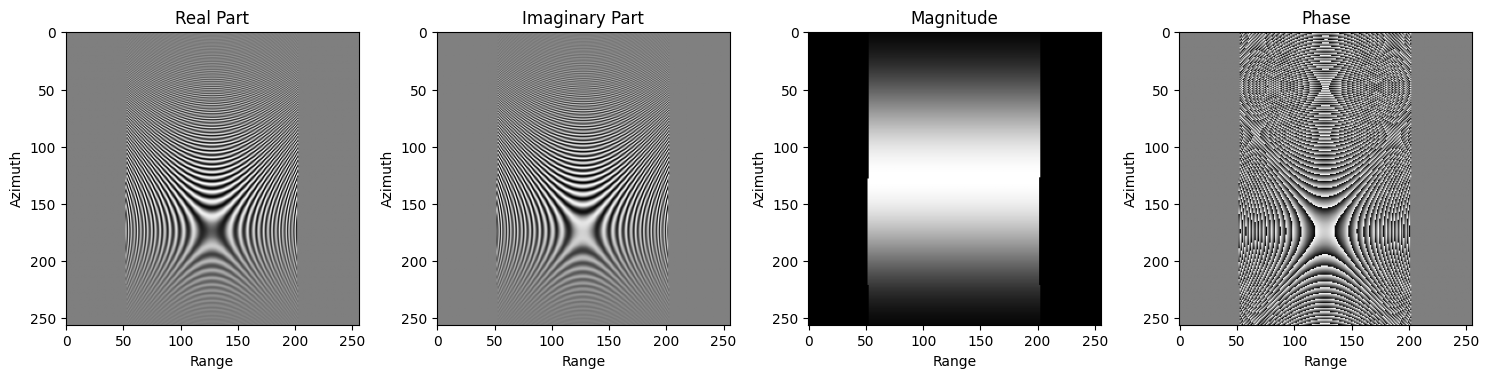

In [5]:
visualization(s0)

### Range Compression

In [6]:
S0 = fft(s0, axis=1)

fr = fftshift(fftfreq(Nrg, 1 / Fr))

Gf = np.where(np.abs(fr) <= Br / 2, 1, 0) * np.exp(1j * np.pi * fr**2 / Kr)
Gf = ifftshift(Gf)

src = ifft(S0 * Gf, axis=1)

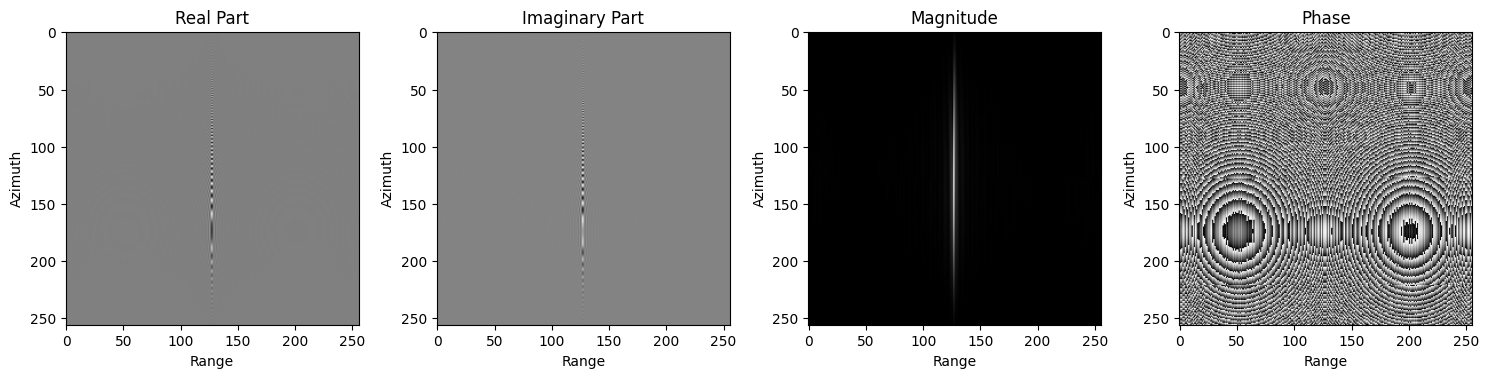

In [7]:
visualization(src)

### Azimuth FFT

In [8]:
zero_doppler = np.exp(-1j * 2 * np.pi * fdc * eta)

src_demod = src * zero_doppler[:, np.newaxis]

S1 = fft(src_demod, axis=0)

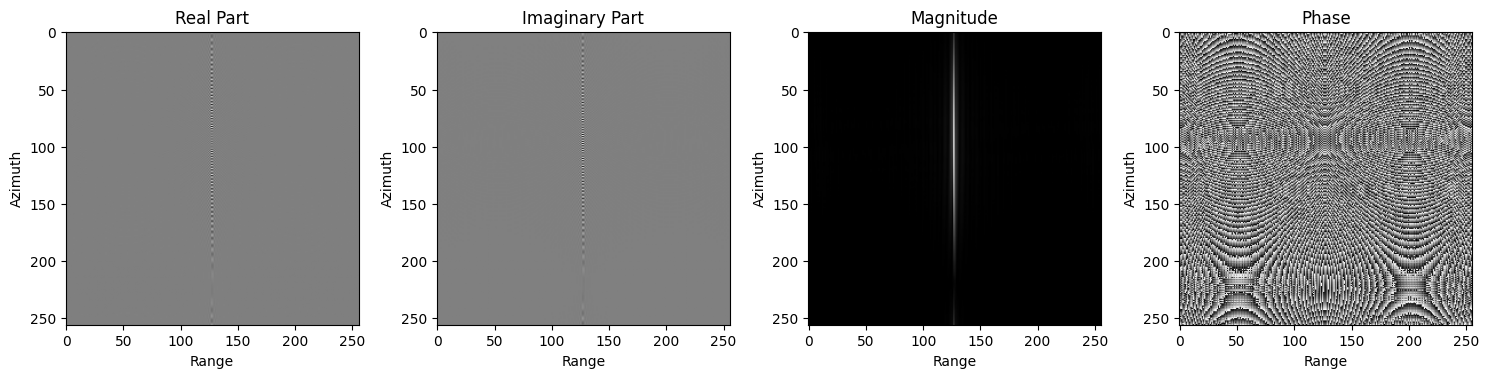

In [9]:
visualization(S1)

### Range Cell Migration Correction (RCMC)

### Azimuth Compression

In [10]:
from scipy.ndimage import shift

Ka = -2 * Vr**2 * f0 / (c * R0)

f_eta = fftshift(fftfreq(Naz, 1 / PRF))

H_az = np.exp(1j * np.pi * f_eta**2 / Ka)
H_az = ifftshift(H_az)

S3 = S1 * H_az[:, np.newaxis]

sac = fftshift(ifft(S3, axis=0), axes=0)
sac = shift(sac, [-eta_c * PRF, 0])  # desloca a imagem para compensar o squint_angle

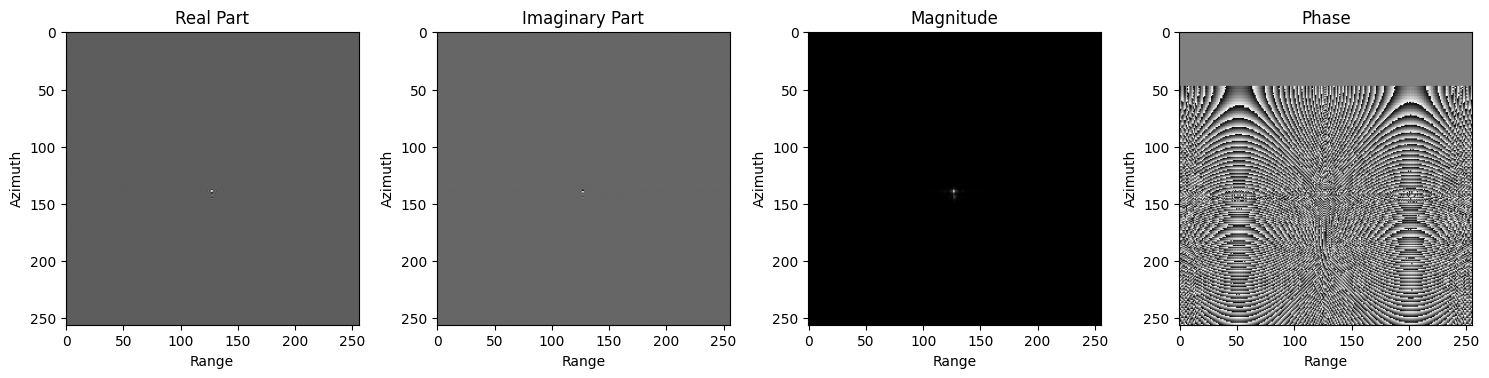

In [11]:
visualization(sac)